In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *
from numpy import linspace

[IC-D46G33P392:30013] shmem: mmap: an error occurred while determining whether or not /var/folders/4g/kvmb0gkn7t59x2_pjvrrk9nh0000gp/T//ompi.IC-D46G33P392.502/jf.0/1519714304/sm_segment.IC-D46G33P392.502.5a950000.0 could be created.


In [3]:
from firedrake.adjoint import *
continue_annotation()

True

In [23]:
n = 100
with stop_annotating():
    mesh = PeriodicIntervalMesh(n, length=2)
x = SpatialCoordinate(mesh)[0]
nu = Constant(1e-2)
V = FunctionSpace(mesh, "Lagrange", 2)
u_n1 = Function(V, name="u^{n+1}")
u_n = Function(V, name="u^{n}")
v = TestFunction(V)
u_init = Function(V).interpolate(sin(2*pi*x))
u_n.assign(u_init)
dt = 1.0 / n
F = (((u_n1 - u_n)/dt) * v +
     u_n1 * u_n1.dx(0) * v + 
     nu*u_n1.dx(0)*v.dx(0))*dx

In [7]:
results = [Function(u_n)]
t = 0
t_end = 0.1
for t in ProgressBar("Time step").iter(linspace(0.0, t_end, int(t_end/dt))):
    solve(F==0, u_n1)
    u_n.assign(u_n1)
    results.append(Function(u_n))

Time step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 10/10 [0:00:00]


In [8]:
J = assemble(u_n*u_n*dx)

In [9]:
pause_annotation()

In [10]:
get_working_tape().progress_bar = ProgressBar


In [11]:
Jhat = ReducedFunctional(J, Control(u_init))

In [12]:
dJ = Jhat.derivative()

Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 34/34 [0:00:00]


In [13]:
adjoints = [block.get_dependencies()[0].adj_value for block in get_solve_blocks()[::-1]]+ [Jhat.controls[0].adj_value]
adjoints = [a.riesz_representation(riesz_map="L2") for a in adjoints if a] 

In [14]:
Jhat.controls[0].adj_value

Cofunction(FiredrakeDualSpace(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1609eb9d0>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 6)), 443)

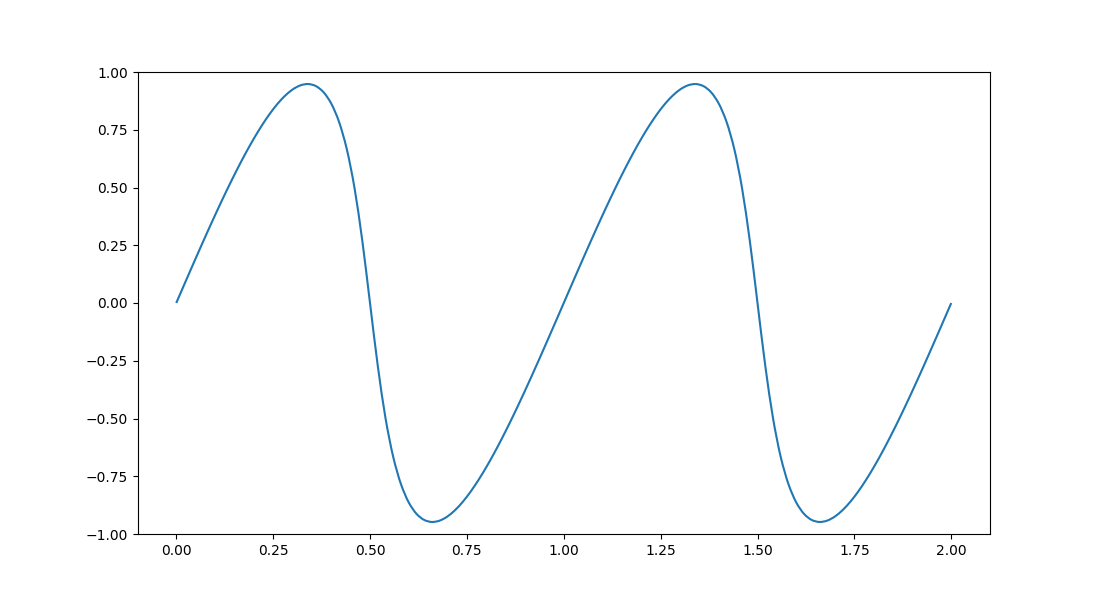

In [19]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import plot
from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots()

def animate(u):
    axes.clear()
    plot(u, axes=axes)
    axes.set_ylim((-1., 1.))

interval = 4e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

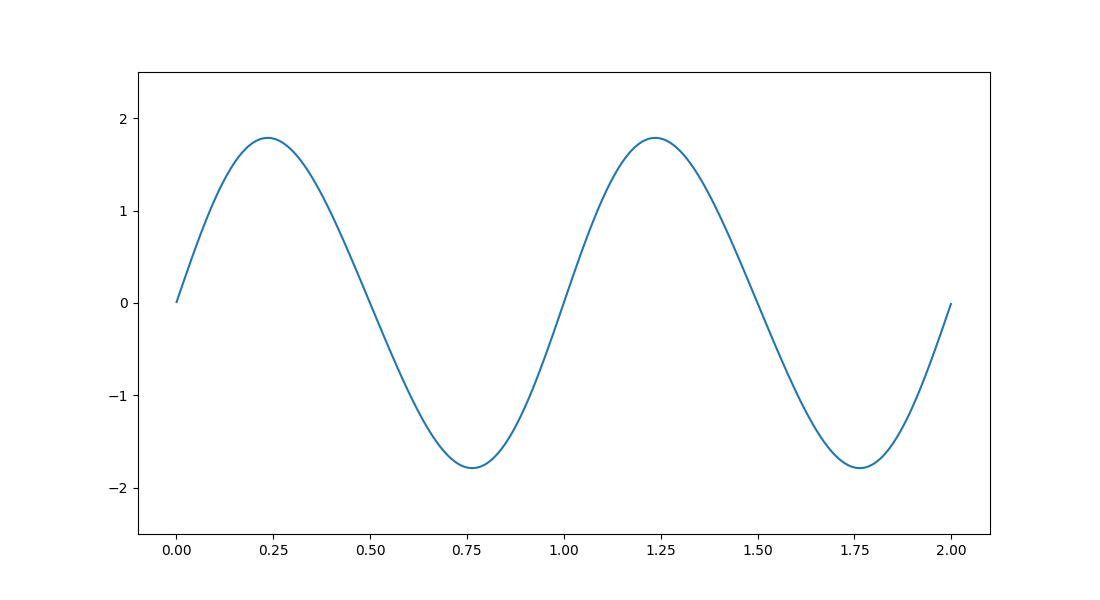

In [22]:
fig, axes = plt.subplots()

def animate(u):
    axes.clear()
    plot(u, axes=axes)
    axes.set_ylim((-2.5, 2.5))

interval = 4e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=adjoints, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

In [ ]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import plot

fig, axes = plt.subplots()

plot(dJ, axes=axes)
plot(results[0], axes=axes)

In [ ]:
tape=get_working_tape()

In [ ]:
tape.visualise("tape.pdf")

In [ ]:
!pip install pdf2image

In [ ]:
from pdf2image import convert_from_path

images = convert_from_path("tape.pdf")
images[0]  # first page

In [ ]:
tape.clear_tape()